# Log Analysis
Apacheデータセット('https://github.com/logpai/loghub/tree/master/Apache')を利用して、ログ解析(アノマリ検知)を行う。

### Import

In [1]:
import sys
import os
import pandas as pd
import datetime
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import  GridSearchCV
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

sys.path.append(os.path.join(os.path.dirname("__file__"), "./src/"))
from data_preprocessing import DataPreprocessing, FeatureExtraction, CreateLabel_Apache, RelatedInfo

### Config

In [2]:
class Config:
    resource_name = "Apache"
    log_data_path = "./data/" + resource_name + "/" + resource_name + "_2k.log"
    feedback_ratio = 0.05
    train_size = 0.8
    th = 0.75
    n_splits = 5
config = Config

### Get Data

In [3]:
with open(config.log_data_path, "r") as f:
    log_data = pd.DataFrame({"log": f.readlines()})
display(log_data)

,log
0,[Sun Dec 04 04:47:44 2005] [notice] workerEnv....
1,[Sun Dec 04 04:47:44 2005] [error] mod_jk chil...
2,[Sun Dec 04 04:51:08 2005] [notice] jk2_init()...
3,[Sun Dec 04 04:51:09 2005] [notice] jk2_init()...
4,[Sun Dec 04 04:51:09 2005] [notice] jk2_init()...
...,...
1995,[Mon Dec 05 19:14:11 2005] [error] mod_jk chil...
1996,[Mon Dec 05 19:15:55 2005] [notice] jk2_init()...
1997,[Mon Dec 05 19:15:55 2005] [notice] jk2_init()...
1998,[Mon Dec 05 19:15:57 2005] [notice] workerEnv....


### Data Preprocessing

In [4]:
log_data_list = []
for i in range(log_data.shape[0]):
    L = str(log_data.values[i][0]).split()
    if len(L) >= 6:
        message_time = L[4][:-1]+"-"+L[1]+"-"+L[2]+" "+L[3]
        message_time = datetime.datetime.strptime(message_time, '%Y-%b-%d %H:%M:%S')
        message = " ".join(L[6:])
        label = L[5][1:-1]
        if label=="notice":
            label=0
        elif label=="error":
            label=1
        log_data_list.append([message_time, message, label])
data = pd.DataFrame(log_data_list, columns=["message_time", "message", "label"])
display(data)

,message_time,message,label
0,2005-12-04 04:47:44,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0
1,2005-12-04 04:47:44,mod_jk child workerEnv in error state 6,1
2,2005-12-04 04:51:08,jk2_init() Found child 6725 in scoreboard slot 10,0
3,2005-12-04 04:51:09,jk2_init() Found child 6726 in scoreboard slot 8,0
4,2005-12-04 04:51:09,jk2_init() Found child 6728 in scoreboard slot 6,0
...,...,...,...
1995,2005-12-05 19:14:11,mod_jk child workerEnv in error state 6,1
1996,2005-12-05 19:15:55,jk2_init() Found child 6791 in scoreboard slot 8,0
1997,2005-12-05 19:15:55,jk2_init() Found child 6790 in scoreboard slot 7,0
1998,2005-12-05 19:15:57,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0


### EDA

In [5]:
data_info = data.groupby(["label"]).size()
display(pd.DataFrame(data_info,columns=["件数"]))

,件数
label,
0,1405
1,595


### Split Data

In [6]:
# 正常/異常データの分割
normal_data = data[data["label"]==0].reset_index(drop=True)
anomaly_data = data[data["label"]==1].reset_index(drop=True)
# feedbackデータと異常データの分割(feedbackのlabelは-1とする)
extract_index = random.sample(range(anomaly_data.shape[0]), k=int(anomaly_data.shape[0] * config.feedback_ratio))
feedback = anomaly_data.iloc[extract_index,:].reset_index(drop=True)
feedback["label"] = -1
anomaly_data = anomaly_data.drop(extract_index).reset_index(drop=True)
# 学習/推論データに分割
data_tmp = pd.concat([normal_data, anomaly_data])
train, test = train_test_split(data_tmp, train_size=config.train_size, shuffle=True, random_state=1)
train = train.sort_values("message_time").reset_index(drop=True)
test = test.sort_values("message_time").reset_index(drop=True)
# 表示
display(train.head())
display(test.head())
display(feedback.head())

,message_time,message,label
0,2005-12-04 04:47:44,mod_jk child workerEnv in error state 6,1
1,2005-12-04 04:51:08,jk2_init() Found child 6725 in scoreboard slot 10,0
2,2005-12-04 04:51:09,jk2_init() Found child 6726 in scoreboard slot 8,0
3,2005-12-04 04:51:14,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0
4,2005-12-04 04:51:14,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0


,message_time,message,label
0,2005-12-04 04:47:44,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0
1,2005-12-04 04:51:09,jk2_init() Found child 6728 in scoreboard slot 6,0
2,2005-12-04 04:51:38,jk2_init() Found child 6733 in scoreboard slot 7,0
3,2005-12-04 04:51:52,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0
4,2005-12-04 04:53:29,jk2_init() Found child 6755 in scoreboard slot 6,0


,message_time,message,label
0,2005-12-05 03:47:54,mod_jk child workerEnv in error state 7,-1
1,2005-12-05 10:33:44,mod_jk child workerEnv in error state 7,-1
2,2005-12-04 20:11:14,mod_jk child workerEnv in error state 6,-1
3,2005-12-04 07:14:29,mod_jk child workerEnv in error state 7,-1
4,2005-12-05 12:36:39,mod_jk child workerEnv in error state 6,-1


### remove parameter

In [7]:
feedback["message_after"] = DataPreprocessing(feedback["message"].values)()
train["message_after"] = DataPreprocessing(train["message"].values)()
test["message_after"] = DataPreprocessing(test["message"].values)()

### feature extraction

In [8]:
train_all = pd.concat([train, feedback]).reset_index(drop=True)
train_feature, vocabulary = FeatureExtraction(train_all["message_after"].values, mode="train", fe_type="tfilf")()
test_feature, _ = FeatureExtraction(test["message_after"].values, mode="test", fe_type="tfilf")()
train_feature = pd.concat([train_feature, train_all["label"]], axis=1)
test_feature = pd.concat([test_feature, test["label"]], axis=1)
display(train_feature.head())
display(test_feature.head())

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,label
0,6.682744,6.682744,7.370929,7.370929,7.370929,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,6.682744,0.000000,7.370929,0.000000,0.000000,7.370929,7.370929,7.370929,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,6.682744,0.000000,7.370929,0.000000,0.000000,7.370929,7.370929,7.370929,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,6.682744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.370929,7.370929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.000000,6.682744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.370929,7.370929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,label
0,0.000000,5.280751,0.000000,0.0,0.0,0.000000,0.000000,0.000000,5.968935,5.968935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5.280751,0.000000,5.968935,0.0,0.0,5.968935,5.968935,5.968935,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5.280751,0.000000,5.968935,0.0,0.0,5.968935,5.968935,5.968935,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,5.280751,0.000000,0.0,0.0,0.000000,0.000000,0.000000,5.968935,5.968935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5.280751,0.000000,5.968935,0.0,0.0,5.968935,5.968935,5.968935,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Create Label
trainデータのlabelをfeedbackデータ(label=-1のデータ)を基にコサイン類似度から生成する。

In [9]:
train_feature = CreateLabel_Apache(train_all, train_feature, config.th)()
display(train_feature.head())

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,label,category,category_pred,related,use_label
0,6.682744,6.682744,7.370929,7.370929,7.370929,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1,child workerEnv in error state,child workerEnv in error state,1.000000,1
1,6.682744,0.000000,7.370929,0.000000,0.000000,7.370929,7.370929,7.370929,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,Found child in scoreboard slot,normal,0.657351,0
2,6.682744,0.000000,7.370929,0.000000,0.000000,7.370929,7.370929,7.370929,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,Found child in scoreboard slot,normal,0.657351,0
3,0.000000,6.682744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.370929,7.370929,...,0.0,0.0,0.0,0.0,0.0,0,workerEnv init ok etc httpd conf properties,normal,0.283643,0
4,0.000000,6.682744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.370929,7.370929,...,0.0,0.0,0.0,0.0,0.0,0,workerEnv init ok etc httpd conf properties,normal,0.283643,0


### Train

In [10]:
params = {"max_length": [5,8,10]}
clf = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=StratifiedKFold(n_splits=config.n_splits), scoring="recall_macro")
model = clf.fit(train_feature.iloc[:,:-5].values, train_feature["use_label"].values) # TF-ILFで特徴量抽出したデータでモデル生成

[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length


### Top10 Keyword

In [11]:
keyword = pd.DataFrame({"word": vocabulary.keys(), "importance":model.best_estimator_.feature_importances_})
keyword = keyword.sort_values("importance", ascending=False)
display(keyword.head(10))

,word,importance
3,error,100
5,Found,100
0,child,97
1,workerEnv,16
14,client,0
22,html,0
21,www,0
20,var,0
19,rule,0
18,by,0


### Train Score
本来の異常とのスコアを算出

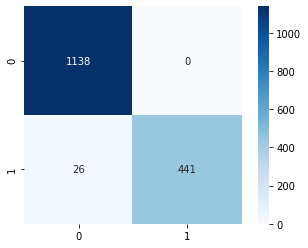

,precision,recall,f1-score,support
0,0.977663,1.000000,0.988705,1138.000000
1,1.000000,0.944325,0.971366,467.000000
accuracy,0.983801,0.983801,0.983801,0.983801
macro avg,0.988832,0.972163,0.980036,1605.000000
weighted avg,0.984162,0.983801,0.983660,1605.000000


In [12]:
y_true = train_feature["label"].apply(lambda x : 1 if x == -1 else x).values
y_pred = model.predict(train_feature.iloc[:,:-5].values)
# scoring
cm = confusion_matrix(y_true, y_pred)
classification_result = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
# display
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

### Test

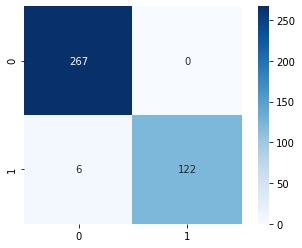

,precision,recall,f1-score,support
0,0.978022,1.000000,0.988889,267.00000
1,1.000000,0.953125,0.976000,128.00000
accuracy,0.984810,0.984810,0.984810,0.98481
macro avg,0.989011,0.976562,0.982444,395.00000
weighted avg,0.985144,0.984810,0.984712,395.00000


In [13]:
test_feature["y_pred"] = model.predict(test_feature.iloc[:,:-1].values)
# scoring
cm = confusion_matrix(test_feature["label"], test_feature["y_pred"])
classification_result = pd.DataFrame(classification_report(test_feature["label"], test_feature["y_pred"], output_dict=True)).T
# display
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

### Visualize Log

In [14]:
all_proba = RelatedInfo(test_feature, train_feature)()
result = pd.concat([test[["message_time", "message","label"]], all_proba], axis=1)
result = result.rename(columns={"label":"【参考】本来のlabel"})
result = result[["message_time", "message", "正常(0)/異常(1)", "関連する過去の障害", "関連度(%)", "【参考】本来のlabel"]]
display(result)

,message_time,message,正常(0)/異常(1),関連する過去の障害,関連度(%),【参考】本来のlabel
0,2005-12-04 04:47:44,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0,-,-,0
1,2005-12-04 04:51:09,jk2_init() Found child 6728 in scoreboard slot 6,0,-,-,0
2,2005-12-04 04:51:38,jk2_init() Found child 6733 in scoreboard slot 7,0,-,-,0
3,2005-12-04 04:51:52,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0,-,-,0
4,2005-12-04 04:53:29,jk2_init() Found child 6755 in scoreboard slot 6,0,-,-,0
...,...,...,...,...,...,...
390,2005-12-05 18:56:04,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0,-,-,0
391,2005-12-05 19:00:44,workerEnv.init() ok /etc/httpd/conf/workers2.p...,0,-,-,0
392,2005-12-05 19:00:54,jk2_init() Found child 6751 in scoreboard slot 10,0,-,-,0
393,2005-12-05 19:00:56,[client 68.228.3.15] Directory index forbidden...,0,-,-,1


In [15]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
result.style.apply(highlight_greaterthan, threshold=1.0, column=['正常(0)/異常(1)'], axis=1)

,message_time,message,正常(0)/異常(1),関連する過去の障害,関連度(%),【参考】本来のlabel
0,2005-12-04 04:47:44,workerEnv.init() ok /etc/httpd/conf/workers2.properties,0,-,-,0
1,2005-12-04 04:51:09,jk2_init() Found child 6728 in scoreboard slot 6,0,-,-,0
2,2005-12-04 04:51:38,jk2_init() Found child 6733 in scoreboard slot 7,0,-,-,0
3,2005-12-04 04:51:52,workerEnv.init() ok /etc/httpd/conf/workers2.properties,0,-,-,0
4,2005-12-04 04:53:29,jk2_init() Found child 6755 in scoreboard slot 6,0,-,-,0
5,2005-12-04 04:54:18,workerEnv.init() ok /etc/httpd/conf/workers2.properties,0,-,-,0
6,2005-12-04 04:57:20,jk2_init() Found child 8539 in scoreboard slot 7,0,-,-,0
7,2005-12-04 04:57:20,jk2_init() Found child 8536 in scoreboard slot 6,0,-,-,0
8,2005-12-04 04:57:24,workerEnv.init() ok /etc/httpd/conf/workers2.properties,0,-,-,0
9,2005-12-04 04:58:18,mod_jk child workerEnv in error state 6,1,child workerEnv in error state,100.0,1


In [16]:
test_feature

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,label,y_pred
0,0.000000,5.280751,0.000000,0.0,0.0,0.000000,0.000000,0.000000,5.968935,5.968935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
1,5.280751,0.000000,5.968935,0.0,0.0,5.968935,5.968935,5.968935,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
2,5.280751,0.000000,5.968935,0.0,0.0,5.968935,5.968935,5.968935,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
3,0.000000,5.280751,0.000000,0.0,0.0,0.000000,0.000000,0.000000,5.968935,5.968935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
4,5.280751,0.000000,5.968935,0.0,0.0,5.968935,5.968935,5.968935,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.000000,5.280751,0.000000,0.0,0.0,0.000000,0.000000,0.000000,5.968935,5.968935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
391,0.000000,5.280751,0.000000,0.0,0.0,0.000000,0.000000,0.000000,5.968935,5.968935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
392,5.280751,0.000000,5.968935,0.0,0.0,5.968935,5.968935,5.968935,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
393,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.968935,5.968935,5.968935,5.968935,5.968935,5.968935,5.968935,0.0,1,0
